# Download Datasets

In [1]:
!pip install torchmetrics
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, util
import json
import os
import zipfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from torchmetrics.classification import BinaryAccuracy
import pytorch_lightning as pl
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [3]:
zip_path = '/content/QMSum.zip'
extract_path = '/content/QMSum'

In [4]:
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed.")

Extraction completed.


In [5]:
QMSum_path = '/content/QMSum/QMSum'

In [6]:
files = {
    "train": [],
    "val": [],
    "test": []
}

for split in files.keys():
    for file in os.listdir(f"{QMSum_path}/data/ALL/{split}"):
        if file.endswith(".json"):
            files[split].append(f"{QMSum_path}/data/ALL/{split}/{file}")

# One Utterance + Cross Encoder Score Datasets

## Class Dataset

In [7]:
class UttCrossEncDatasets(Dataset):
    def __init__(self, json_files: List[str], encoder):
        self.data = []  # store each example here
        self.encoder = encoder

        for json_file in json_files:
            file_info = self._load_json(json_file)
            self.data.append(file_info)

    def _load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # chunk and encode the utterances
        utterances = [f"{i} {t['speaker']}: {t['content']}" for i,t in enumerate(data['meeting_transcripts'])]

        questions = []

        for item in data['specific_query_list']:
            query = item['query']

            spans = item['relevant_text_span']
            labels = [0] * len(utterances)

            for span in spans:
                start, end = int(span[0]), int(span[1])
                for i in range(start, end + 1):
                    labels[i] = 1

            labels = torch.tensor(labels, dtype=torch.float32)
            scores = self.score_utterances(query, utterances)

            questions.append({
                'query': query,
                'scores': scores,
                'labels': labels,
            })

        file_info = {
            "utterances": utterances,
            "questions": questions
        }
        return file_info
    def score_utterances(self, query, utterances):
        query_emb = self.encoder.encode(query)
        utterances_emb = self.encoder.encode(utterances)
        scores = util.dot_score(query_emb, utterances_emb)[0].cpu().tolist()
        return scores

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'utterances': item['utterances'],
            'questions': item['questions']
        }

In [8]:
encoder_model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.25k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
print("Datasets are loading...")
train_dataset = UttCrossEncDatasets(files['train'], encoder_model)
val_dataset = UttCrossEncDatasets(files['val'], encoder_model)
test_dataset = UttCrossEncDatasets(files['test'], encoder_model)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Datasets are loading...
Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35


### Score Analysis

In [10]:
def plot_scores(dataset, data_idx, question_idx):
    question = train_dataset[data_idx]['questions'][question_idx]
    scores = question['scores']
    labels = question['labels']

    scores = scores.detach().cpu().numpy() if hasattr(scores, "detach") else scores
    labels = labels.detach().cpu().numpy() if hasattr(labels, "detach") else labels

    x = list(range(len(scores)))
    colors = ['green' if label == 1 else 'red' for label in labels]

    plt.figure(figsize=(12, 6))
    plt.scatter(x, scores, c=colors)
    plt.xlabel("Utterance Index")
    plt.ylabel("Relevance Score")
    plt.title(f"Utterance Relevance Scores")
    plt.grid(True)
    plt.show()


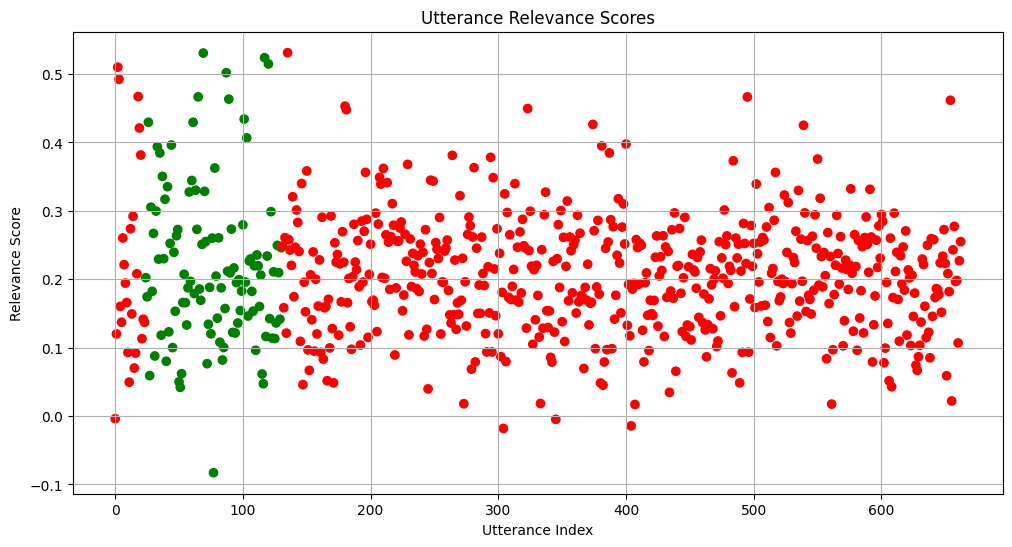

In [11]:
plot_scores(train_dataset, 111, 0)

In [12]:
def evaluate_topk_accuracy(dataset, top_k):
    """
    Evaluates the fraction of questions where at least one of the top-k scoring utterances is relevant.

    Args:
        dataset (UttCrossEncDatasets): The dataset object.
        top_k (int): The number of top scoring utterances to consider.

    Returns:
        float: Fraction of questions with at least one relevant utterance in the top-k.
    """
    total_questions = 0
    correct_count = 0
    correct_labels = 0
    total_labels = 0

    for example in dataset.data:
        for question in example['questions']:
            scores = question['scores']
            labels = question['labels']

            # Get indices of top-k scores
            topk_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]

            # Check if any of the top-k indices have label 1
            if any(labels[i] == 1 for i in topk_indices):
                correct_count += 1

            for i in topk_indices:
                if labels[i] == 1:
                  correct_labels += 1
                total_labels += 1

            total_questions += 1

    is_in_accuracy = correct_count / total_questions if total_questions > 0 else 0.0
    accuracy = correct_labels / total_labels if total_labels > 0 else 0.0

    return is_in_accuracy, accuracy

In [13]:
is_in_accuracy, accuracy = evaluate_topk_accuracy(train_dataset, top_k=5)
print(f"Top-{5} is_in_accuracy: {is_in_accuracy:.2f}")
print(f"Top-{5} accuracy: {accuracy:.2f}")

Top-5 is_in_accuracy: 0.76
Top-5 accuracy: 0.33


In [14]:
is_in_accuracy, accuracy = evaluate_topk_accuracy(train_dataset, top_k=3)
print(f"Top-{3} is_in_accuracy: {is_in_accuracy:.2f}")
print(f"Top-{3} accuracy: {accuracy:.2f}")

Top-3 is_in_accuracy: 0.67
Top-3 accuracy: 0.37


In [15]:
is_in_accuracy, accuracy = evaluate_topk_accuracy(train_dataset, top_k=1)
print(f"Top-{1} is_in_accuracy: {is_in_accuracy:.2f}")
print(f"Top-{1} accuracy: {accuracy:.2f}")

Top-1 is_in_accuracy: 0.45
Top-1 accuracy: 0.45


In [16]:
def max_utterance_lenght(dataset):
    max_length = 0
    for item in dataset:
        length = len(item['utterances'])
        if length > max_length:
            max_length = length
    print(f"max utterances in the dataset is {max_length}")
    return max_length

In [17]:
max_utterance_lenght(train_dataset)
max_utterance_lenght(val_dataset)
max_utterance_lenght(test_dataset)

max utterances in the dataset is 1832
max utterances in the dataset is 1259
max utterances in the dataset is 1368


1368

## fix length span

In [18]:
def predict_labels_fix_lenght_span(dataset, span_size, top_k=5):
  metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': [],
        'iou': [],
        'percent_intersect': []
    }

  for item in dataset:
    utterances = item['utterances']
    questions = item['questions']
    for question in questions:
      scores = question['scores']
      labels = question['labels']

      scores_tensor = torch.tensor(scores)
      topk = torch.topk(scores_tensor, top_k)
      topk_indices = topk.indices.tolist()

      predicted_labels = [0] * len(utterances)
      for i in topk_indices:
        start = max(0, i - span_size // 2)
        end = min(len(utterances), i + span_size // 2 + 1)
        for j in range(start, end):
                    predicted_labels[j] = 1

      # Compute metrics
      pred = torch.tensor(predicted_labels)
      true = torch.tensor(labels).int()

      intersection = (pred & true).sum().item()
      union = (pred | true).sum().item()
      total_pred_1 = pred.sum().item()

      precision = precision_score(true, pred, zero_division=0)
      recall = recall_score(true, pred, zero_division=0)
      f1 = f1_score(true, pred, zero_division=0)
      accuracy = accuracy_score(true, pred)
      iou = intersection / union if union > 0 else 0.0
      percent_intersect = intersection / total_pred_1 if total_pred_1 > 0 else 0.0

      metrics['precision'].append(precision)
      metrics['recall'].append(recall)
      metrics['f1'].append(f1)
      metrics['accuracy'].append(accuracy)
      metrics['iou'].append(iou)
      metrics['percent_intersect'].append(percent_intersect)

    # Average over all questions
    avg_metrics = {k: sum(v)/len(v) if len(v) > 0 else 0.0 for k, v in metrics.items()}
    return avg_metrics, metrics

In [19]:
span_size = 128
top_k = 5
avg_metrics, metrics = predict_labels_fix_lenght_span(test_dataset, span_size, top_k)

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

In [20]:
print(avg_metrics)

{'precision': 0.0803056745209171, 'recall': 1.0, 'f1': 0.13866613895464192, 'accuracy': 0.14160401002506265, 'iou': 0.0803056745209171, 'percent_intersect': 0.0803056745209171}


In [21]:
def plot_metrics_by_span_and_topk(dataset, span_sizes: List[int], top_ks: List[int], dataset_name):
    import matplotlib.pyplot as plt
    import numpy as np

    metric_names = ['recall', 'precision', 'f1', 'accuracy', 'iou', 'percent_intersect']
    results = {metric: [] for metric in metric_names}
    labels = []

    for span in span_sizes:
        for top_k in top_ks:
            avg_metrics, _ = predict_labels_fix_lenght_span(dataset, span, top_k)
            for metric in metric_names:
                results[metric].append(avg_metrics[metric])
            labels.append(f"span={span}\ntop_k={top_k}")

    x = np.arange(len(labels))
    width = 0.15

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 6))
    for idx, metric in enumerate(metric_names):
        values = results[metric]
        bar_positions = x + idx * width
        bars = ax.bar(bar_positions, values, width, label=metric)
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Span Size (utterances) & Top-K Combinations')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Evaluation Metrics on {dataset_name} for Different Span Sizes and Top-Ks')
    ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()


In [22]:
def plot_all_fix_span(dataset, dataset_name):
    #first plot
    span_sizes = [1, 2, 4]
    top_ks = [1, 3, 5]
    plot_metrics_by_span_and_topk(train_dataset, span_sizes, top_ks, dataset_name)

    #second plot
    span_sizes = [8, 16, 32]
    top_ks = [1, 3, 5]
    plot_metrics_by_span_and_topk(train_dataset, span_sizes, top_ks, dataset_name)

    #third plot
    span_sizes = [64, 128, 256]
    top_ks = [1, 3, 5]
    plot_metrics_by_span_and_topk(train_dataset, span_sizes, top_ks, dataset_name)

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

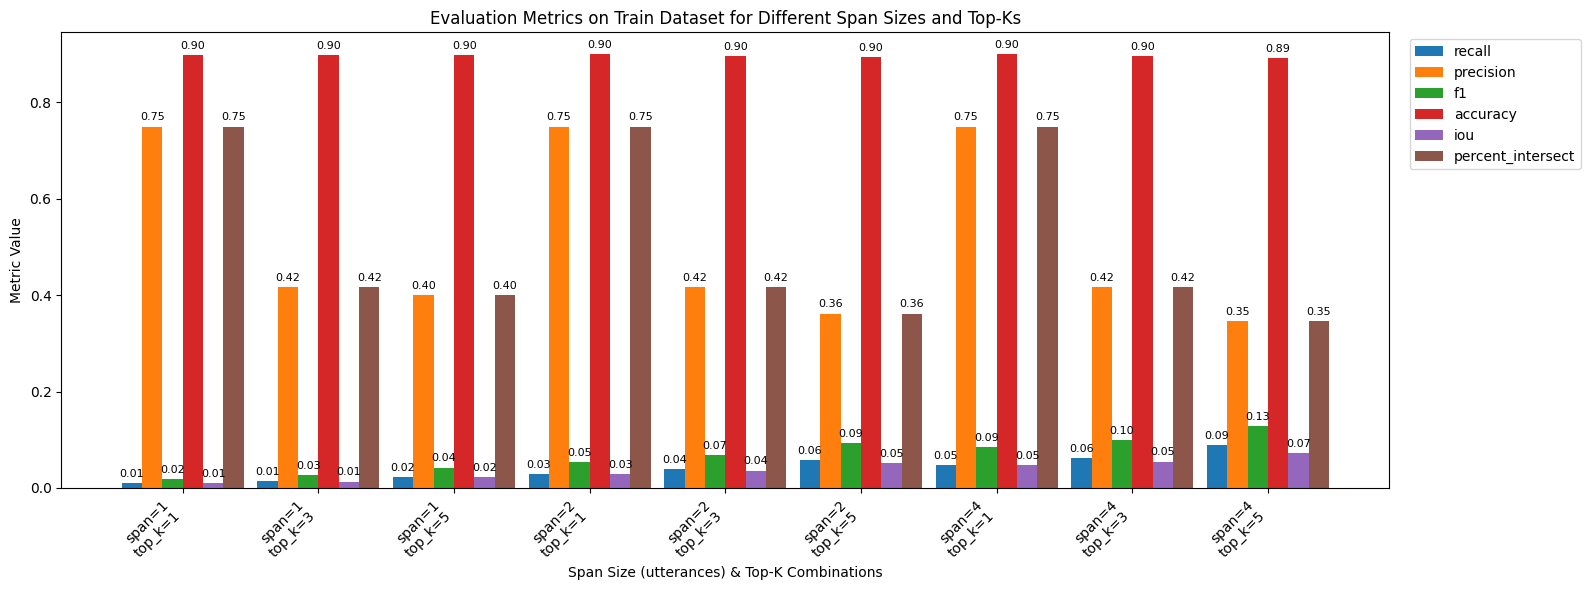

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

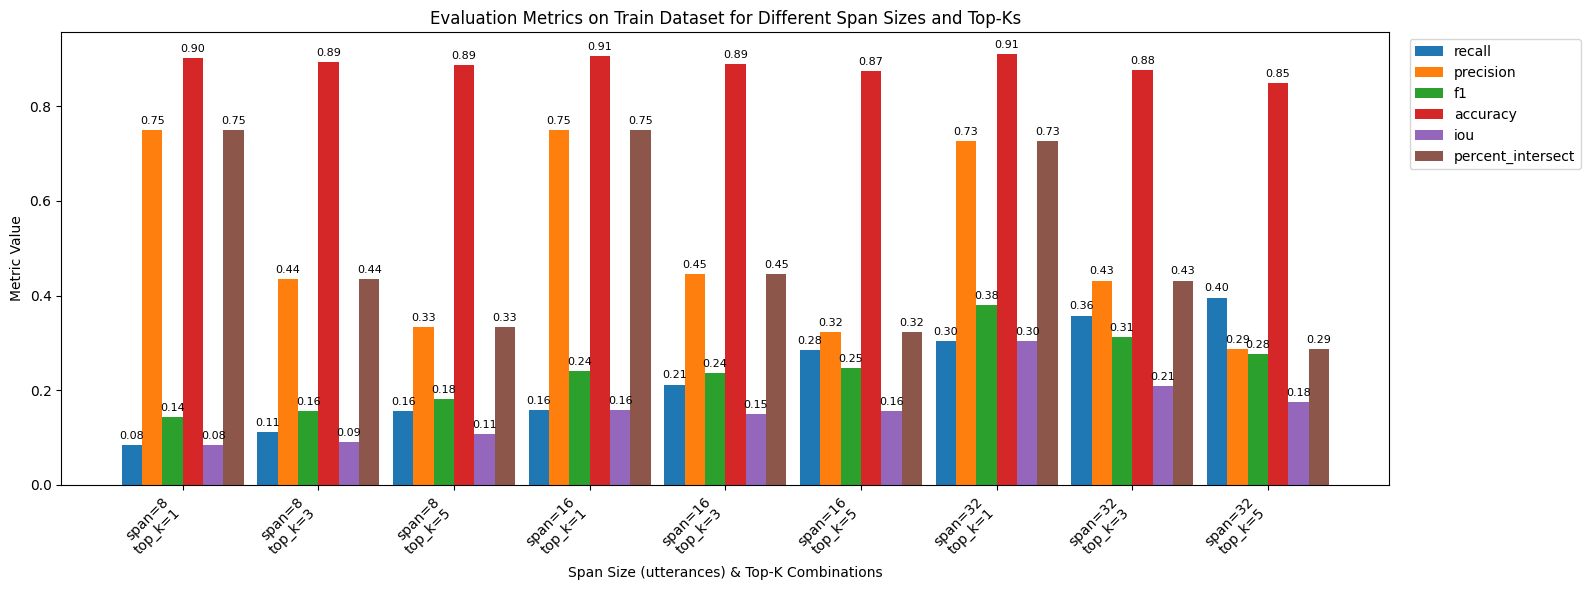

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

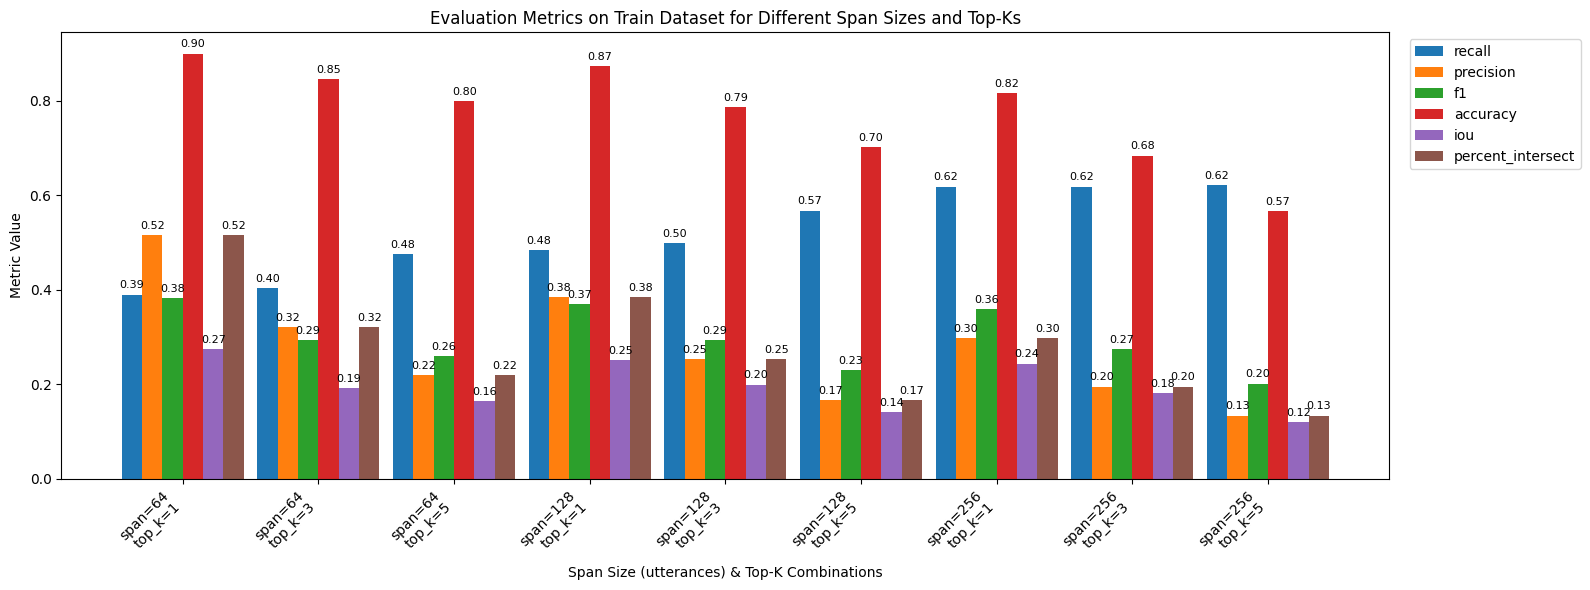

In [23]:
plot_all_fix_span(train_dataset, "Train Dataset")

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

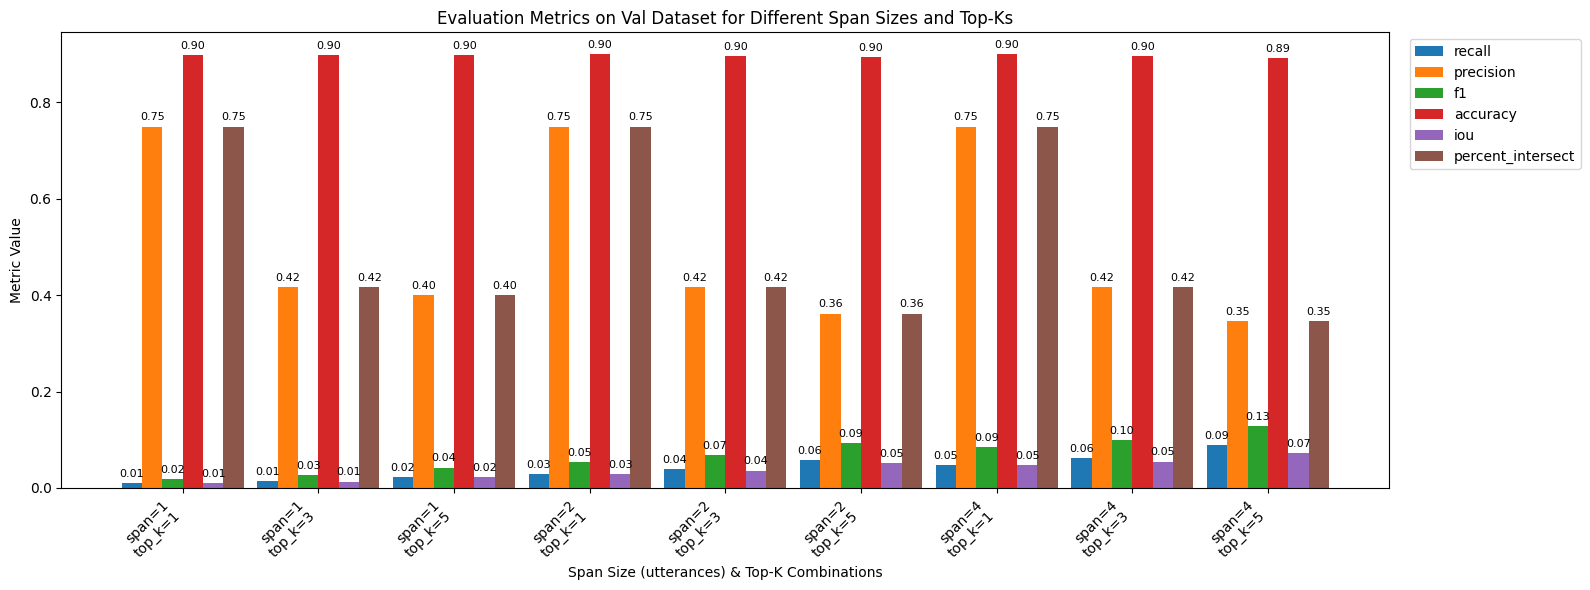

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

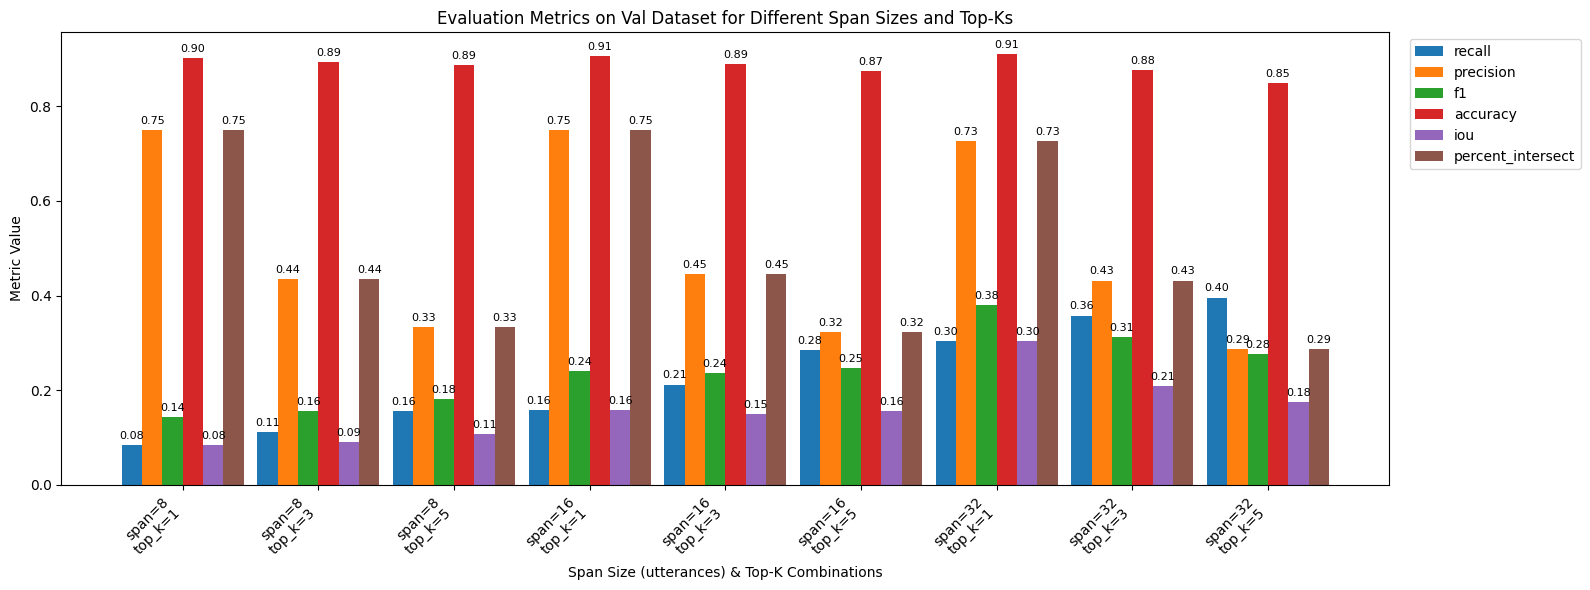

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

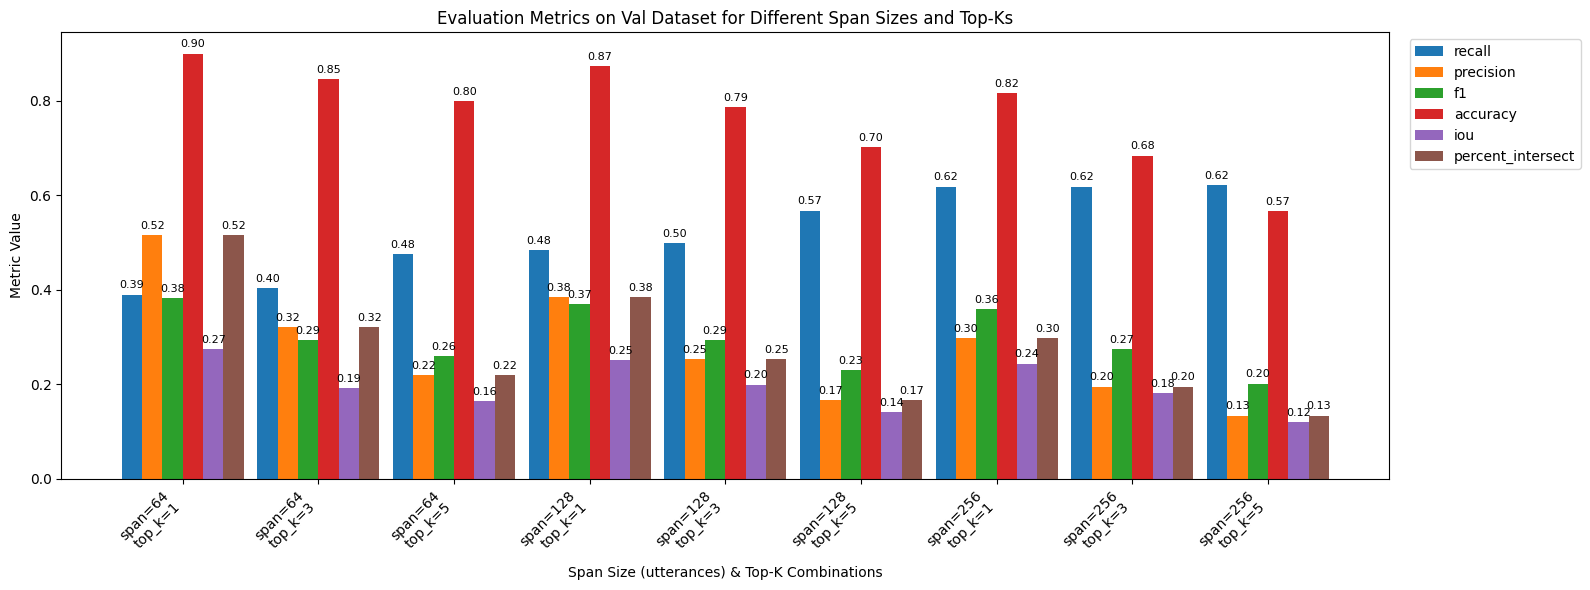

In [24]:
plot_all_fix_span(val_dataset, "Val Dataset")

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

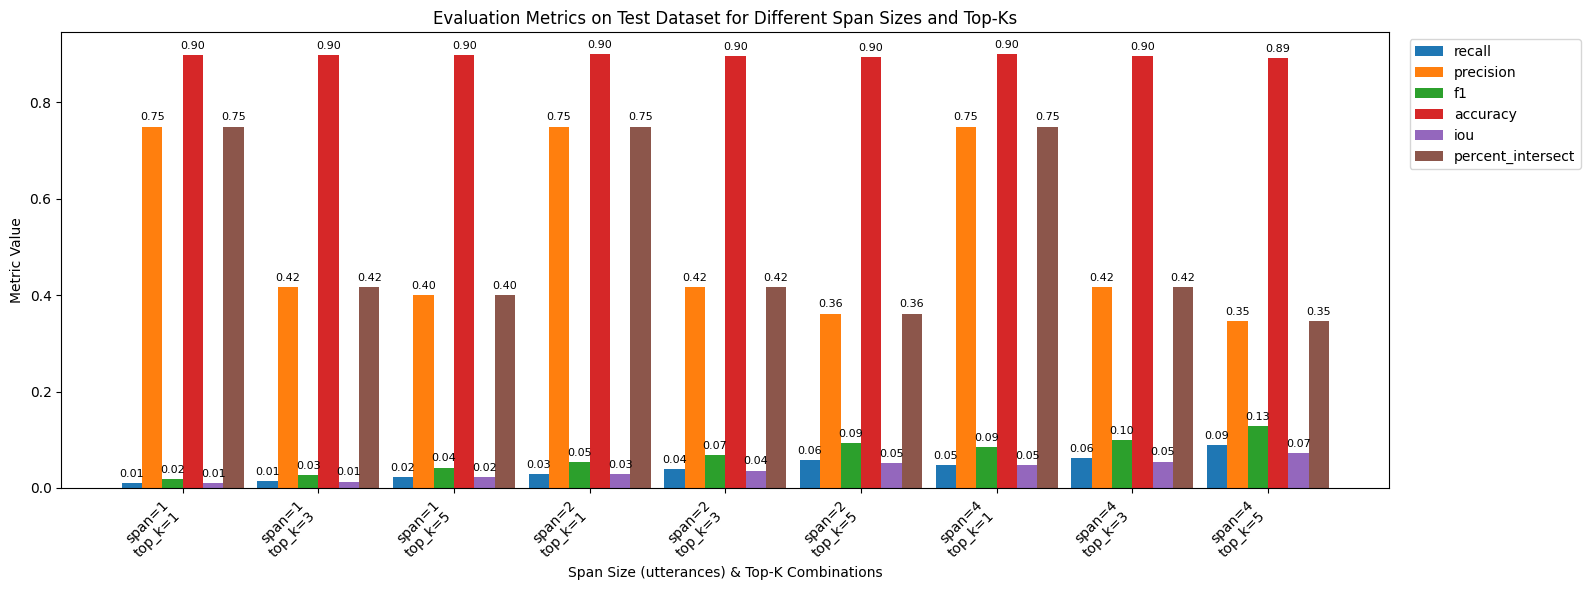

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

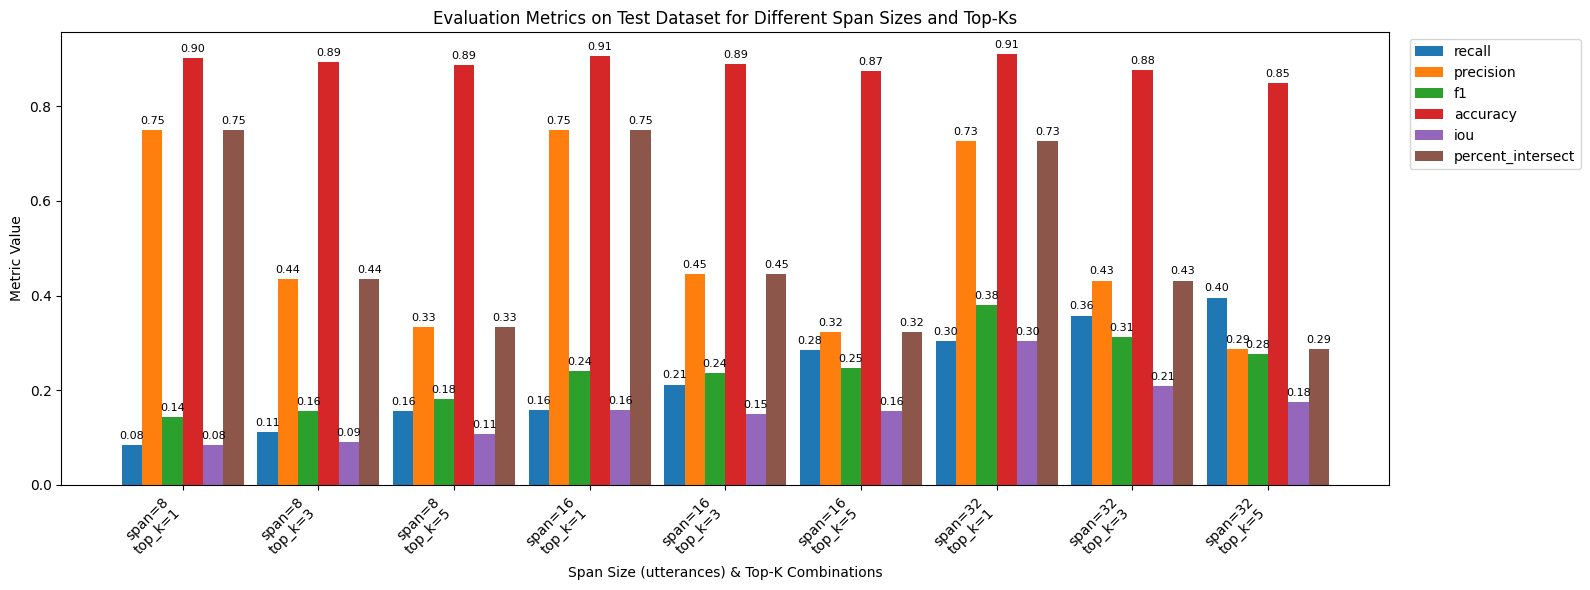

<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-18-59d4e154e5f3>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

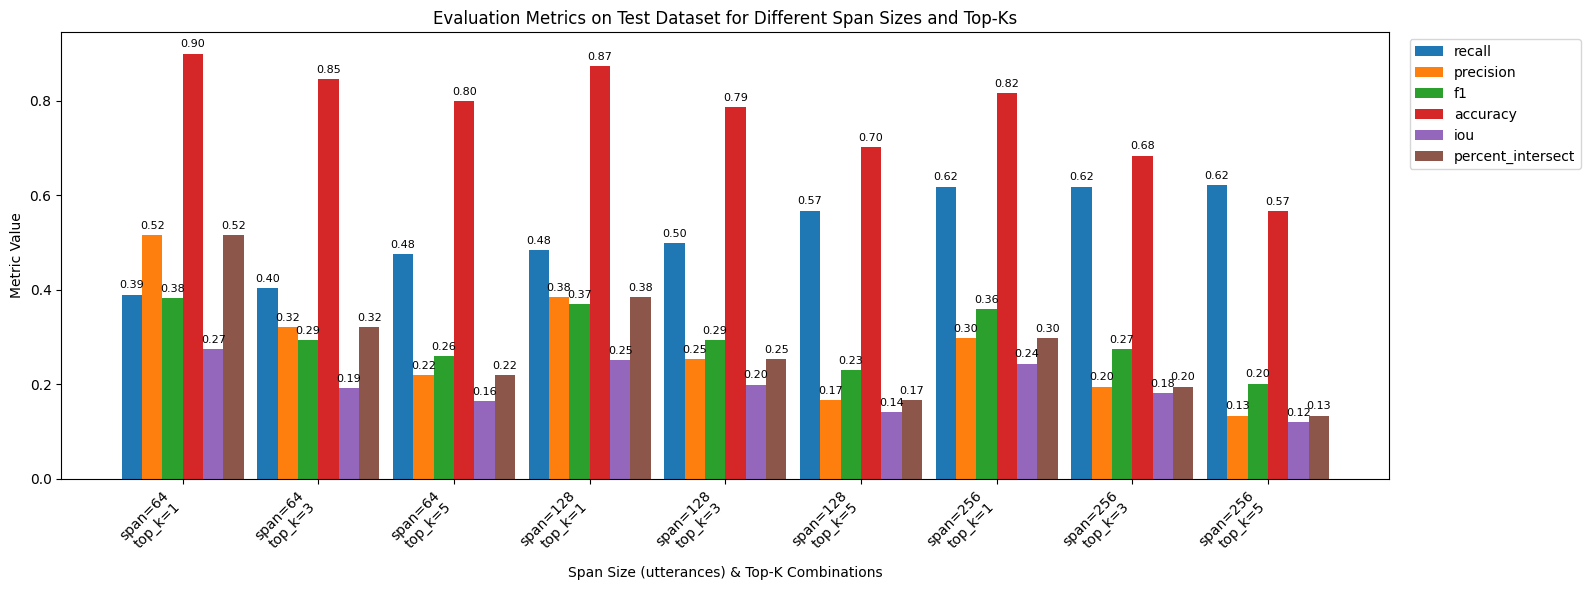

In [25]:
plot_all_fix_span(test_dataset, "Test Dataset")

## Semantic chunk span

In [26]:
!pip install semchunk
!pip install tiktoken transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.8/272.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.2 MB/s eta 0:00:00


In [27]:
import semchunk

In [28]:
def find_chunk_range_from_utt_index(chunk_ranges, utt_index):
    for start, end in chunk_ranges:
        if start <= utt_index <= end:
            return start, end

In [29]:
def predict_labels_semantic_chunk_span(dataset, chunk_size, top_k=5):
  metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': [],
        'iou': [],
        'percent_intersect': []
    }

  chunker = semchunk.chunkerify('gpt-4', chunk_size=chunk_size)

  for item in dataset:
    utterances = item['utterances']
    questions = item['questions']

    #semantic chunking
    utterances_chunks = chunker("\n".join(utterances))
    chunk_ranges = []
    sentence_ind = 0
    for chunk in utterances_chunks:
      chunk_len = len(chunk.split("\n"))
      chunk_ranges.append((sentence_ind, sentence_ind + chunk_len - 1))

      sentence_ind += chunk_len

    for question in questions:
      scores = question['scores']
      labels = question['labels']

      scores_tensor = torch.tensor(scores)
      topk = torch.topk(scores_tensor, top_k)
      topk_indices = topk.indices.tolist()

      predicted_labels = [0] * len(utterances)
      for i in topk_indices:
        start, end = find_chunk_range_from_utt_index(chunk_ranges, i)
        for j in range(start, end):
                    predicted_labels[j] = 1

      # Compute metrics
      pred = torch.tensor(predicted_labels)
      true = torch.tensor(labels).int()

      intersection = (pred & true).sum().item()
      union = (pred | true).sum().item()
      total_pred_1 = pred.sum().item()

      precision = precision_score(true, pred, zero_division=0)
      recall = recall_score(true, pred, zero_division=0)
      f1 = f1_score(true, pred, zero_division=0)
      accuracy = accuracy_score(true, pred)
      iou = intersection / union if union > 0 else 0.0
      percent_intersect = intersection / total_pred_1 if total_pred_1 > 0 else 0.0

      metrics['precision'].append(precision)
      metrics['recall'].append(recall)
      metrics['f1'].append(f1)
      metrics['accuracy'].append(accuracy)
      metrics['iou'].append(iou)
      metrics['percent_intersect'].append(percent_intersect)

    # Average over all questions
    avg_metrics = {k: sum(v)/len(v) if len(v) > 0 else 0.0 for k, v in metrics.items()}
    return avg_metrics, metrics

In [30]:
def plot_metrics_by_chunksize_and_topk(dataset, chunk_sizes: List[int], top_ks: List[int], dataset_name):
    import matplotlib.pyplot as plt
    import numpy as np

    metric_names = ['recall', 'precision', 'f1', 'accuracy', 'iou', 'percent_intersect']
    results = {metric: [] for metric in metric_names}
    labels = []

    for chunk_size in chunk_sizes:
        for top_k in top_ks:
            avg_metrics, _ = predict_labels_semantic_chunk_span(dataset, chunk_size, top_k)
            for metric in metric_names:
                results[metric].append(avg_metrics[metric])
            labels.append(f"chunk_size={chunk_size}\ntop_k={top_k}")

    x = np.arange(len(labels))
    width = 0.15

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 6))
    for idx, metric in enumerate(metric_names):
        values = results[metric]
        bar_positions = x + idx * width
        bars = ax.bar(bar_positions, values, width, label=metric)
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Chunk Size (tokens) & Top-K Combinations')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Evaluation Metrics on {dataset_name} for Different Chunk Sizes and Top-Ks')
    ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()


In [31]:
def plot_all_chunk_spans(dataset, dataset_name):
  #first plot
  chunk_sizes = [64, 128, 256]
  top_ks = [1, 3, 5]
  plot_metrics_by_chunksize_and_topk(train_dataset, chunk_sizes, top_ks, dataset_name)

  #second plot
  chunk_sizes = [512, 1024, 2048]
  top_ks = [1, 3, 5]
  plot_metrics_by_chunksize_and_topk(train_dataset, chunk_sizes, top_ks, dataset_name)

<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

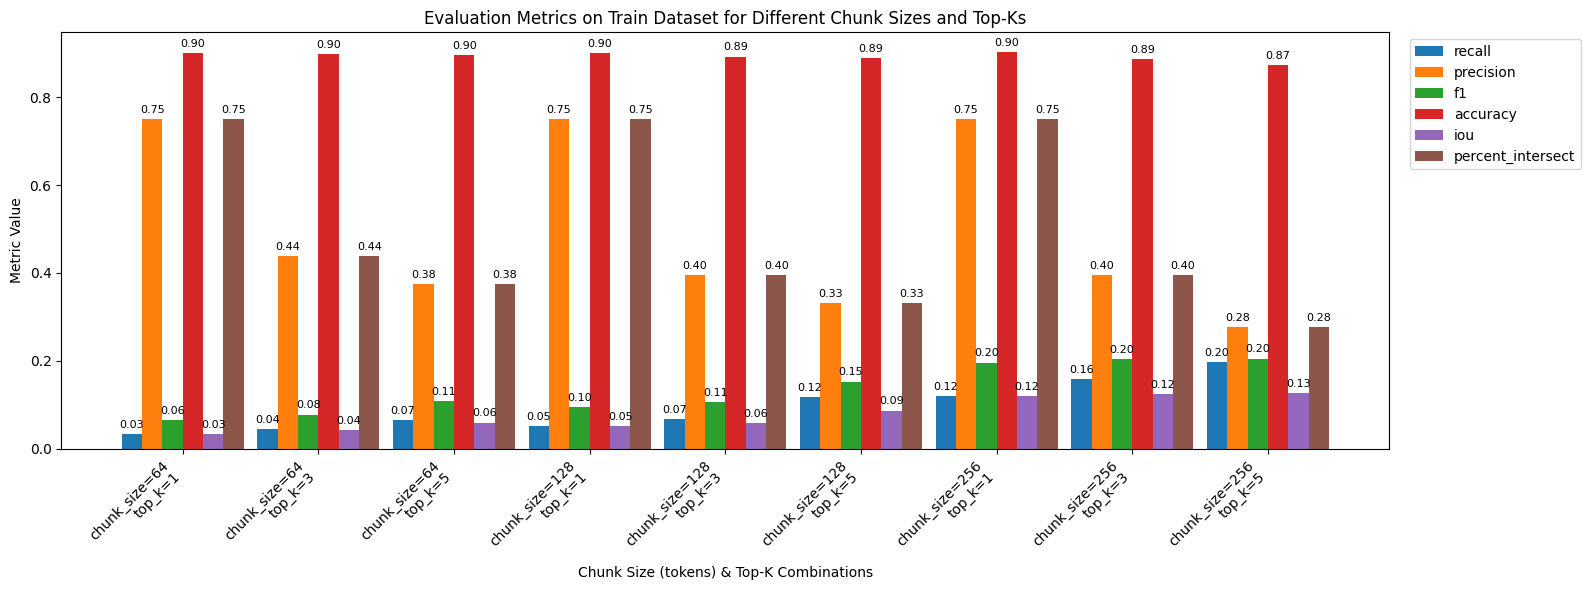

<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

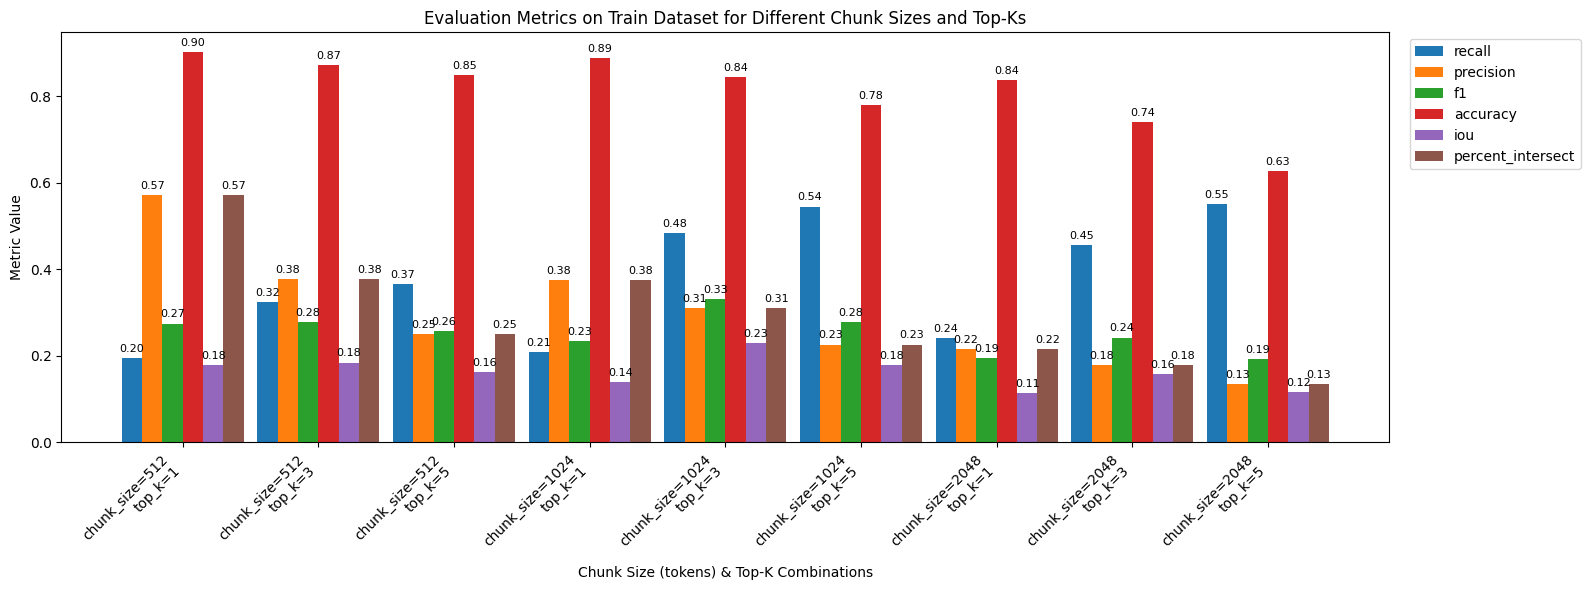

In [32]:
plot_all_chunk_spans(train_dataset, "Train Dataset")

<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

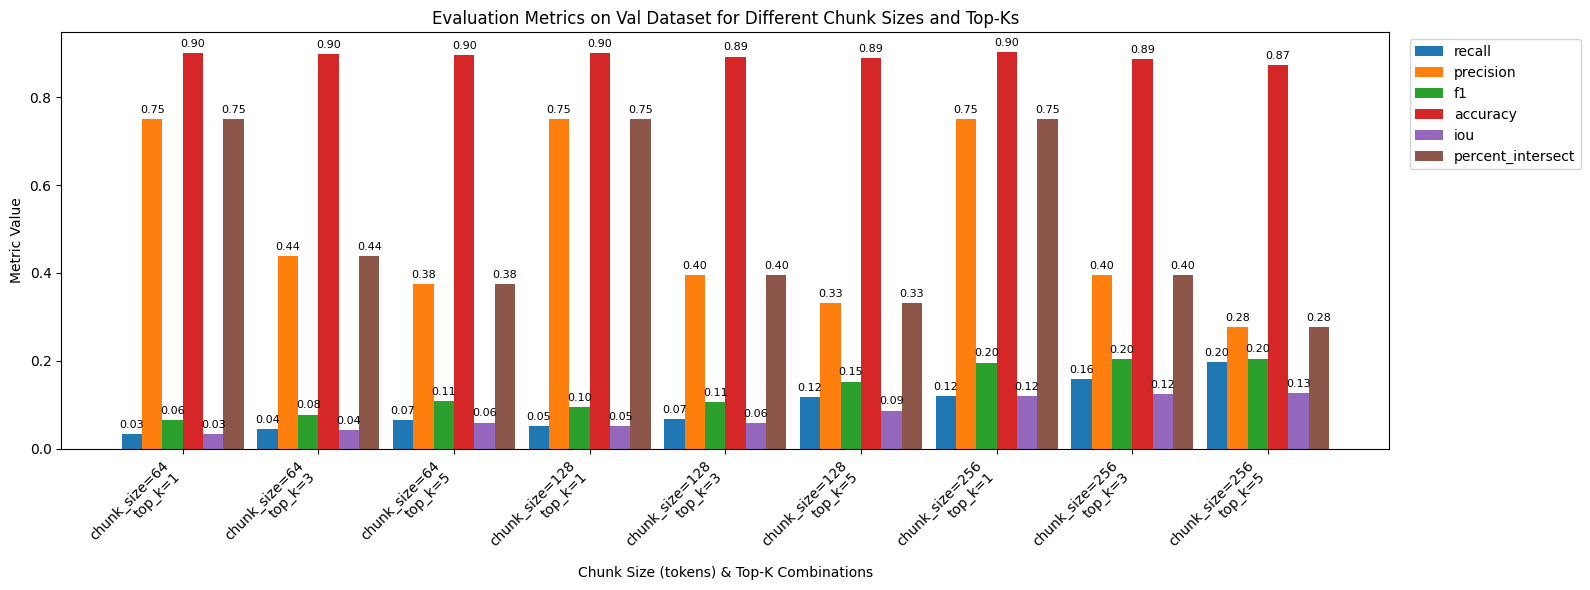

<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

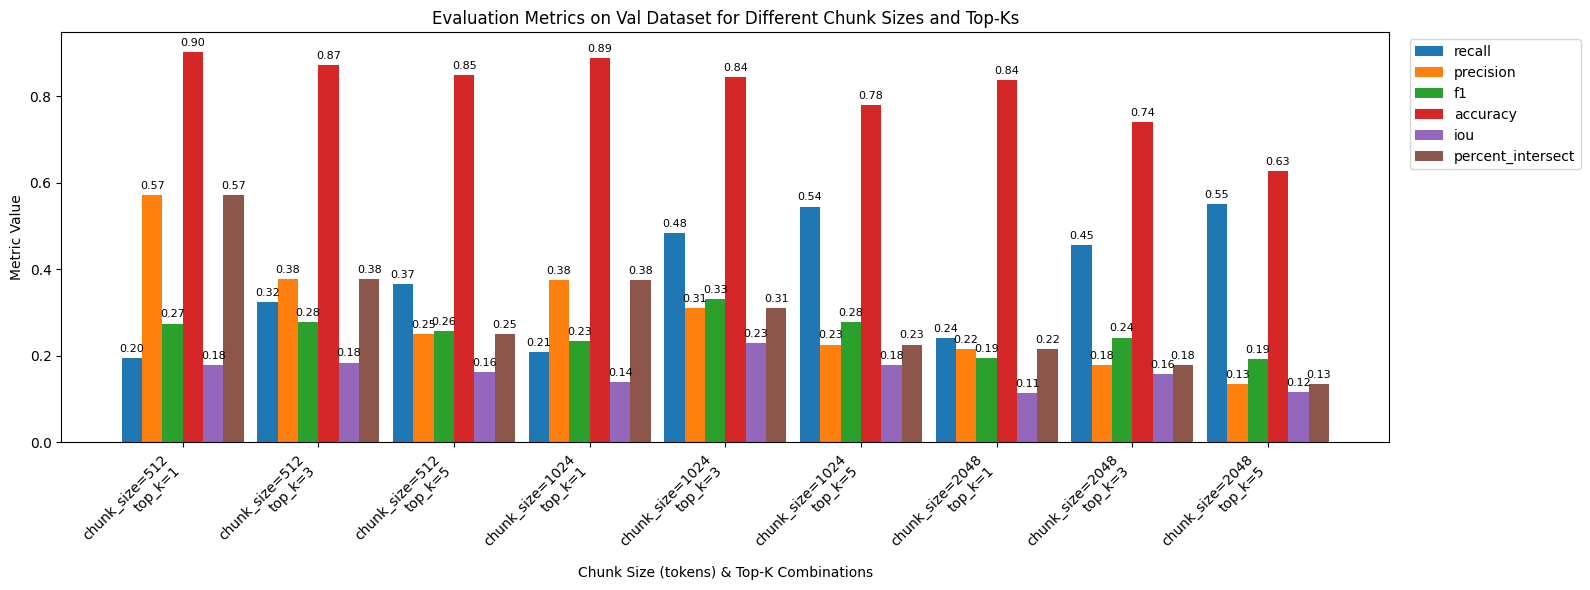

In [33]:
plot_all_chunk_spans(val_dataset, "Val Dataset")

<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

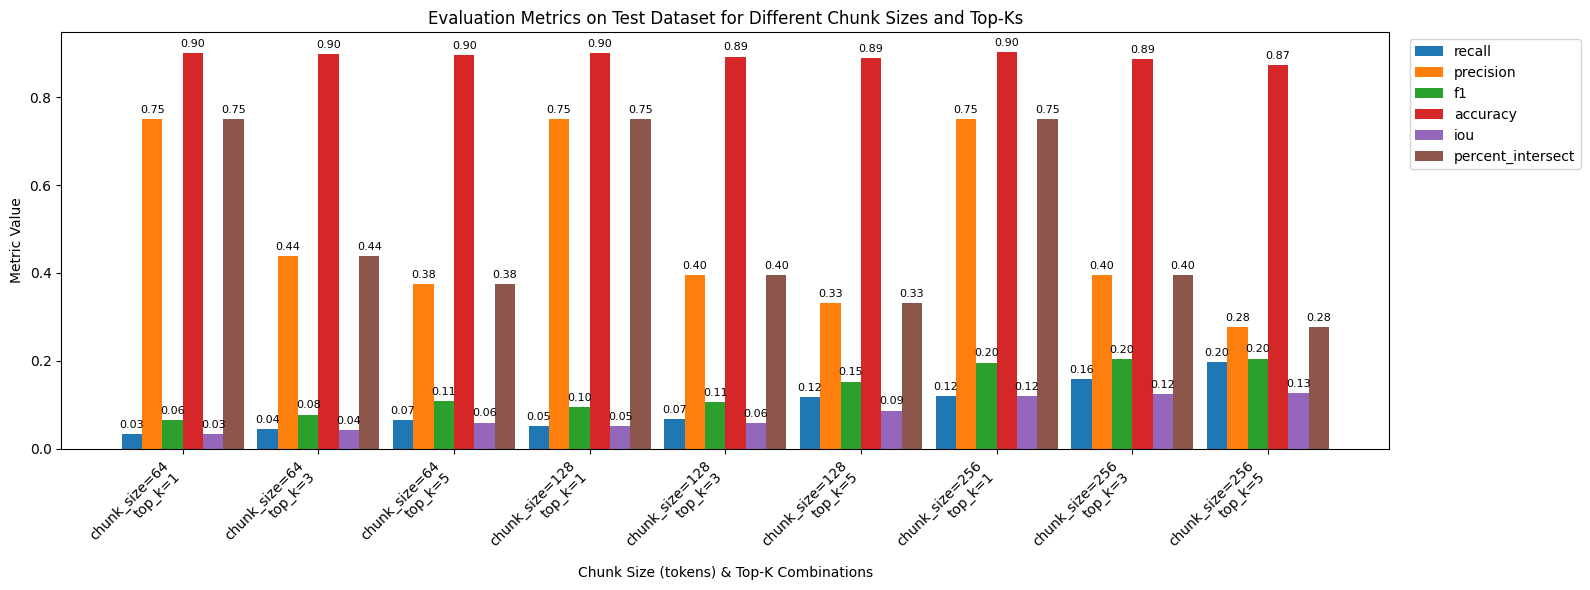

<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-29-e4bf7cd99b50>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

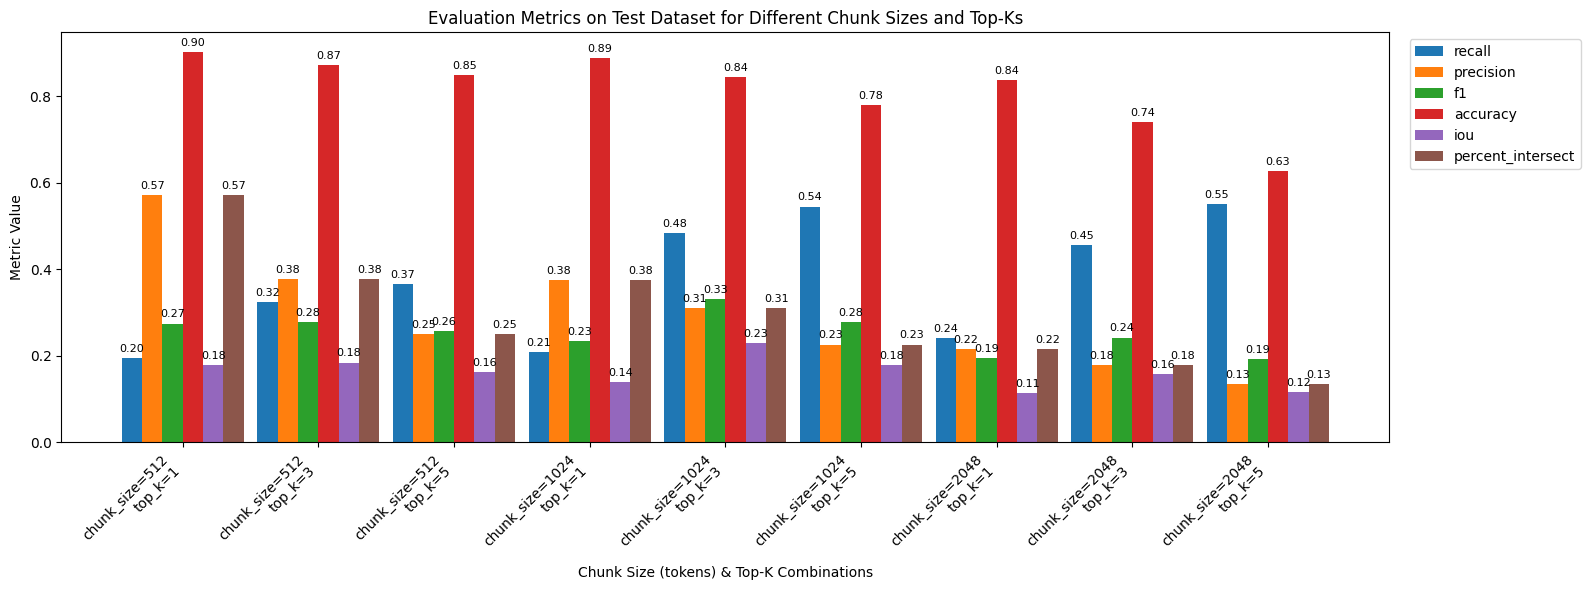

In [34]:
plot_all_chunk_spans(test_dataset, "Test Dataset")

# Semantic Chunk + Cross Encoder Score Datasets

## Class Dataset

In [35]:
!pip install semchunk
!pip install tiktoken transformers

In [36]:
import semchunk

In [37]:
class ChunkCrossEncDatasets(Dataset):
    def __init__(self, json_files: List[str], encoder, chunk_size):
        self.data = []  # store each example here
        self.encoder = encoder
        self.chunk_size = chunk_size

        self.chunker = semchunk.chunkerify('gpt-4', chunk_size=chunk_size)

        for json_file in json_files:
            file_info = self._load_json(json_file)
            self.data.append(file_info)

    def _load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)

        # chunk and encode the utterances
        utterances = [f"{i} {t['speaker']}: {t['content']}" for i,t in enumerate(data['meeting_transcripts'])]
        utterances_chunks = self.chunker("\n".join(utterances))

        questions = []

        for item in data['specific_query_list']:
            query = item['query']

            spans = item['relevant_text_span']
            labels = [0] * len(utterances)

            for span in spans:
                start, end = int(span[0]), int(span[1])
                for i in range(start, end + 1):
                    labels[i] = 1

            labels = torch.tensor(labels, dtype=torch.float32)
            scores = self.score_utterances_chunks(query, utterances_chunks, len(utterances))

            questions.append({
                'query': query,
                'scores': scores,
                'labels': labels,
            })

        file_info = {
            "utterances": utterances,
            "questions": questions
        }
        return file_info
    def score_utterances_chunks(self, query, utterances_chunks, utterance_length):
        scores = {}
        sentence_ind = 0
        query_emb = self.encoder.encode(query)
        for chunk in utterances_chunks:
          chunk_len = len(chunk.split("\n"))

          #score the chunk
          chunk_emb = self.encoder.encode(chunk)
          chunk_score = util.dot_score(query_emb, chunk_emb)[0].cpu().tolist()[0]

          end_ind = sentence_ind + chunk_len - 1
          if(end_ind > utterance_length - 1):
            break
          scores[(sentence_ind, end_ind)] = chunk_score
          sentence_ind = end_ind + 1

        return scores

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'utterances': item['utterances'],
            'questions': item['questions']
        }

In [38]:
def load_datasets(files, encoder, chunk_size):
  print("Datasets are loading...")
  train_dataset = ChunkCrossEncDatasets(files['train'], encoder, chunk_size)
  val_dataset = ChunkCrossEncDatasets(files['val'], encoder, chunk_size)
  test_dataset = ChunkCrossEncDatasets(files['test'], encoder, chunk_size)

  print(f"Train dataset size: {len(train_dataset)}")
  print(f"Validation dataset size: {len(val_dataset)}")
  print(f"Test dataset size: {len(test_dataset)}")
  return train_dataset, val_dataset, test_dataset

Note: The cross-encoder/ms-marco-MiniLM-L6-v2 model has a maximum token limit of 512

cross-encoder/ms-marco-MiniLM-L6-v2 uses the WordPiece tokenizer, which generally produces fewer tokens for the same text compared to GPT-4.

GPT-4 uses Byte Pair Encoding (BPE), specifically OpenAI's cl100k_base, which may result in more tokens for the same text.

As a rough estimate, 512 tokens in MiniLM could expand to around 600–900 tokens in GPT-4

In [39]:
encoder_model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

In [40]:
chunk_size = 512
train_dataset, val_dataset, test_dataset = load_datasets(files, encoder_model, chunk_size)

Datasets are loading...
Train dataset size: 162
Validation dataset size: 35
Test dataset size: 35


In [41]:
print(test_dataset[-1]["questions"][-1]["scores"])

{(0, 33): 0.22583208978176117, (34, 42): 0.22536805272102356, (43, 63): 0.212882861495018, (64, 85): 0.14460232853889465, (86, 109): 0.08104836940765381, (110, 134): 0.07278676331043243, (135, 160): 0.1470826417207718, (161, 188): 0.20899845659732819, (189, 202): 0.12842024862766266, (203, 216): 0.13129475712776184, (217, 237): 0.13495786488056183, (238, 264): 0.10417186468839645, (265, 291): 0.09284977614879608, (292, 317): 0.21266818046569824, (318, 339): 0.1284349262714386, (340, 362): 0.3200681209564209, (363, 386): 0.015305048786103725, (387, 410): 0.36136120557785034, (411, 436): 0.2890974283218384, (437, 466): 0.1477285772562027, (467, 497): 0.05760568380355835, (498, 517): 0.1476798802614212, (518, 545): 0.0923372283577919, (546, 572): 0.394625186920166, (573, 603): 0.3217330574989319}


### Score Analysis

In [42]:
def plot_scores_chunk_dataset(dataset, data_idx, question_idx):
    question = train_dataset[data_idx]['questions'][question_idx]
    scores = question['scores']
    labels = question['labels']

    scores = scores.detach().cpu().numpy() if hasattr(scores, "detach") else scores
    labels = labels.detach().cpu().numpy() if hasattr(labels, "detach") else labels

    scores_list = [0] * len(labels)
    for chunk_range, score in scores.items():
      start, end = chunk_range
      for i in range(start, end + 1):
        scores_list[i] = score

    x = list(range(len(scores_list)))
    colors = ['green' if label == 1 else 'red' for label in labels]

    plt.figure(figsize=(12, 6))
    plt.scatter(x, scores_list, c=colors)
    plt.xlabel("Utterance Index")
    plt.ylabel("Relevance Score")
    plt.title(f"Utterance Relevance Scores")
    plt.grid(True)
    plt.show()


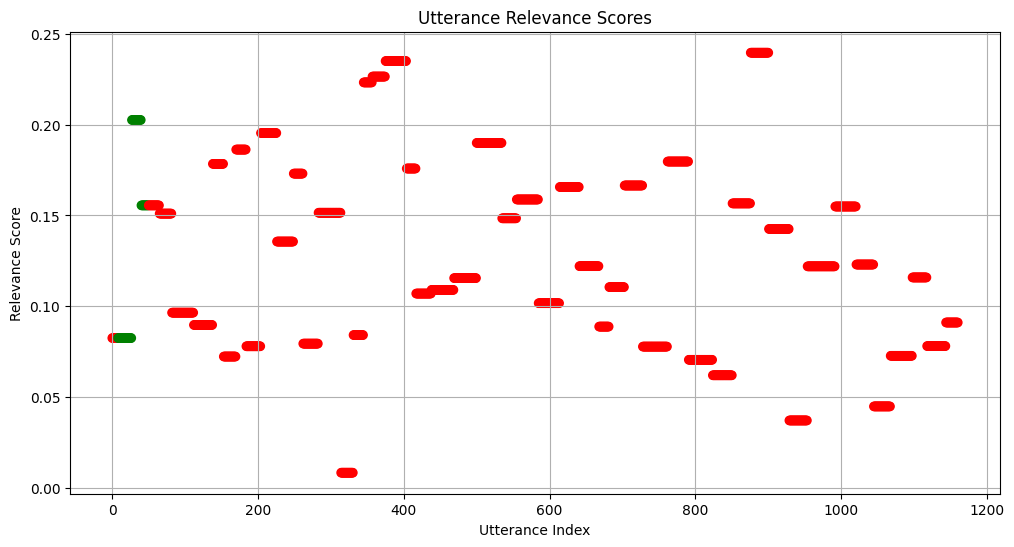

In [43]:
plot_scores_chunk_dataset(train_dataset, 20, 0)

## Top-k chunks retrieval

In [44]:
def predict_labels_semantic_chunk_span_cross_enc(dataset, top_k=5):
  metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': [],
        'iou': [],
        'percent_intersect': []
    }

  for item in dataset:
    utterances = item['utterances']
    questions = item['questions']
    for question in questions:
      scores = question['scores']
      labels = question['labels']

      top_k_chunks = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
      top_k_chunk_ranges = [chunk_range for chunk_range, score in top_k_chunks]

      predicted_labels = [0] * len(utterances)
      for start, end in top_k_chunk_ranges:
        for j in range(start, end):
                    predicted_labels[j] = 1

      # Compute metrics
      pred = torch.tensor(predicted_labels)
      true = torch.tensor(labels).int()

      intersection = (pred & true).sum().item()
      union = (pred | true).sum().item()
      total_pred_1 = pred.sum().item()

      precision = precision_score(true, pred, zero_division=0)
      recall = recall_score(true, pred, zero_division=0)
      f1 = f1_score(true, pred, zero_division=0)
      accuracy = accuracy_score(true, pred)
      iou = intersection / union if union > 0 else 0.0
      percent_intersect = intersection / total_pred_1 if total_pred_1 > 0 else 0.0

      metrics['precision'].append(precision)
      metrics['recall'].append(recall)
      metrics['f1'].append(f1)
      metrics['accuracy'].append(accuracy)
      metrics['iou'].append(iou)
      metrics['percent_intersect'].append(percent_intersect)

    # Average over all questions
    avg_metrics = {k: sum(v)/len(v) if len(v) > 0 else 0.0 for k, v in metrics.items()}
    return avg_metrics, metrics

In [45]:
def plot_chunk_metrics_by_chunksize_and_topk_on_test(files, encoder_model, chunk_sizes: List[int], top_ks: List[int], dataset_name='Test Dataset'):
    import matplotlib.pyplot as plt
    import numpy as np

    metric_names = ['recall', 'precision', 'f1', 'accuracy', 'iou', 'percent_intersect']
    results = {metric: [] for metric in metric_names}
    labels = []

    for chunk_size in chunk_sizes:
        print("Test Dataset is loading ...")
        test_dataset = ChunkCrossEncDatasets(files['test'], encoder_model, chunk_size)
        for top_k in top_ks:
            avg_metrics, _ = predict_labels_semantic_chunk_span_cross_enc(test_dataset, top_k)
            for metric in metric_names:
                results[metric].append(avg_metrics[metric])
            labels.append(f"chunk_size={chunk_size}\ntop_k={top_k}")

    x = np.arange(len(labels))
    width = 0.15

    # Plotting
    fig, ax = plt.subplots(figsize=(16, 6))
    for idx, metric in enumerate(metric_names):
        values = results[metric]
        bar_positions = x + idx * width
        bars = ax.bar(bar_positions, values, width, label=metric)
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Chunk Size (tokens) & Top-K Combinations')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Evaluation Metrics on {dataset_name} for Different Chunk Sizes and Top-Ks (Chunked Dataset)')
    ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.show()


Test Dataset is loading ...


<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

Test Dataset is loading ...


<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

Test Dataset is loading ...


<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

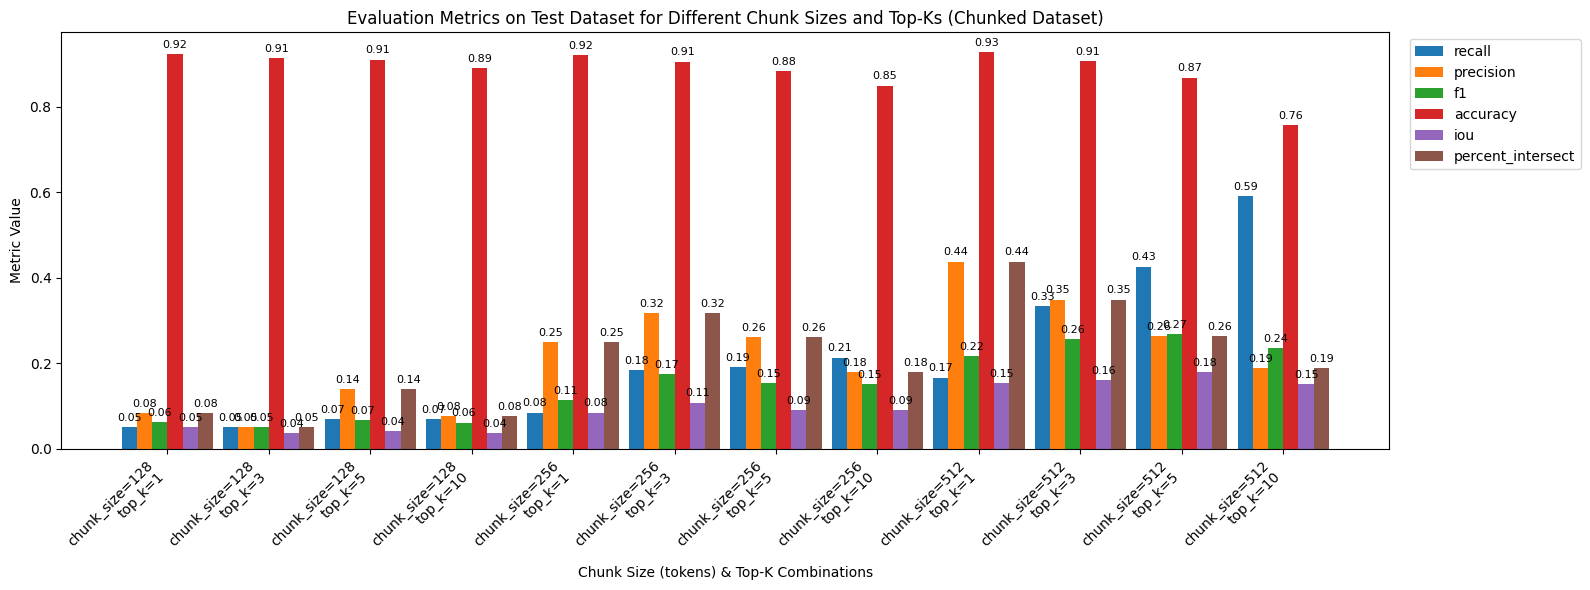

In [46]:
chunk_sizes = [128, 256, 512]
top_ks = [1, 3, 5, 10]
plot_chunk_metrics_by_chunksize_and_topk_on_test(files, encoder_model, chunk_sizes, top_ks, dataset_name='Test Dataset')

In [47]:
avg_metrics, metrics = predict_labels_semantic_chunk_span_cross_enc(train_dataset, top_k=5)

<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(labels).int()
<ipython-input-44-bad188a7c400>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rath

In [48]:
print(avg_metrics)

{'precision': 0.11805362733088336, 'recall': 0.20855183642483993, 'f1': 0.12996419022102762, 'accuracy': 0.8022782750203417, 'iou': 0.07100711789162964, 'percent_intersect': 0.11805362733088336}
